Цель работы: Исследовать и применить различные архитектуры нейронных сетей для решения задачи классификации на выбранном датасете, включая базовые модели (однослойный и многослойный перцептрон) и более сложной гибридной архитектуры, сочетающей в себе слои внимания и сверточные слои.

Задачи:

* Ознакомиться с теоретической основой нейронных сетей, включая однослойные и многослойные перцептроны, а также механизмы внимания и сверточные слои.
* Обработать данные (дз 1).
* Реализовать обучение моделей.
* Провести подбор гиперпараметров с помощью Optuna.
* Выбрать качественные метрики и провести оценку моделей.
* Сравнить результаты моделей с и без оптимизации гиперпараметров.
* Визуализировать процесс обучения с помощью графиков изменения целевой функции.

Теоретическая справка была написана на основе материалов лекций и **уже выполненной** работы, поэтому включает описание используемых технологий.

# Теоретическая справка
## 1. Основы нейронных сетей

### 1.1. Нейрон как базовая единица

Простейшая математическая модель нейрона, вдохновленная биологией, принимает на вход вектор признаков $x$, вычисляет их взвешенную сумму и применяет к результату **функцию активации** $\sigma$.

Предсказывающая функция одного нейрона имеет вид:
$a(x, w) = \sigma(⟨w, x⟩) = \sigma(\sum_{j=i}^{p} w_jx^j - w_0)$  

где:
- $w$ — вектор весов нейрона.
- $w₀$ — смещение (bias), которое можно рассматривать как вес для входа, всегда равного -1.
- $\sigma$ — нелинейная функция активации.

<img src="https://avatars.mds.yandex.net/i?id=06800c6a738e45c87bdfbe9d72b48e4e9233fdc5-11374185-images-thumbs&n=13" alt="Схема нейрона" width="500"/>


### 1.2. Функции активации

Функция активации вносит в модель нелинейность, что позволяет нейронным сетям изучать сложные зависимости. Без них многослойная сеть была бы эквивалентна одному линейному слою.

Основные функции активации:
- **Сигмоида**: $\sigma(z) = \frac{1}{1 + e^{-\alpha z}}$
  - Сжимает выходные значения в диапазон (0, 1). Исторически важна, но сейчас используется реже в скрытых слоях из-за проблемы затухания градиента.
- **Гиперболический тангенс (tanh)**: $\sigma(z) = \frac{e^{\alpha z} - e^{-\alpha z}}{e^{\alpha z} + e^{-\alpha z}}$
  - Сжимает выходные значения в диапазон (-1, 1). Часто сходится быстрее сигмоиды.
- **Выпрямитель (ReLU - Rectified Linear Unit)**: $\sigma(z) = max(0, z)$
  - Самая популярная функция для скрытых слоев. Вычислительно эффективна и помогает бороться с затуханием градиента.
- **Softmax**: $SM_i(z) = \frac{e^{z_i}}{\Sigma_{k=1}^K e^{z_k}}$
  - Используется, как правило, на выходном слое в задачах многоклассовой классификации для преобразования выходов сети в вероятностное распределение по классам.













### 1.3. Функции потерь для классификации

Для задач классификации наиболее распространенной функцией потерь является **перекрестная энтропия (Cross-Entropy)**, которая измеряет расхождение между предсказанным распределением вероятностей и истинным. Для бинарной классификации она тесно связана с логарифмической функцией потерь:

$L(M) = \log(1 + e^{-M})$, где $M = y \cdot a(x)$ (margin).

## 2. Архитектуры нейронных сетей

### 2.1. Однослойная линейная сеть (Перцептрон)

Эта архитектура состоит из одного слоя нейронов, который напрямую соединен со входами. Каждый нейрон независимо обрабатывает входные данные. Такая сеть может находить только **линейные** разделяющие поверхности. Она не способна решить даже простые нелинейные задачи, такие как "Исключающее ИЛИ" (XOR).

### 2.2. Многослойная линейная сеть (MLP)

MLP состоит из входного слоя, одного или нескольких **скрытых слоев** и выходного слоя. Ключевое отличие — наличие скрытых слоев, которые позволяют сети изучать иерархические признаки и строить сложные, нелинейные разделяющие поверхности.

**Теорема об универсальной аппроксимации** (Цыбенко, 1989) гласит, что двухслойная нейронная сеть с нелинейной функцией активации может аппроксимировать любую непрерывную функцию с любой заданной точностью. Это делает MLP мощным инструментом для широкого круга задач.

### 2.3. Гибридная сеть со слоями внимания и свертки

Эта сложная архитектура комбинирует идеи из разных областей для эффективной обработки табличных данных.

1.  **Слой эмбеддингов ($nn.Linear$)**: Входные признаки преобразуются в плотные векторы (эмбеддинги) `hid_dim`. Это позволяет модели работать в более богатом признаковом пространстве.

2.  **Блок внимания (`AttentionBlock`)**:
    *   **Назначение**: Механизм внимания позволяет модели динамически взвешивать важность каждого признака относительно всех остальных для конкретного объекта. Это особенно полезно в табличных данных, где взаимосвязи между столбцами могут быть нетривиальными.
    *   **Работа**: На основе входных эмбеддингов $x$ создаются три матрицы: Запрос (`Query`), Ключ (`Key`) и Значение (`Value`). "Похожесть" между запросом одного признака и ключами всех остальных определяет веса, с которыми суммируются их "значения".
    *   **$MultiheadAttention$**: Внимание применяется параллельно в нескольких "головах", каждая из которых может фокусироваться на разных типах зависимостей.
    *   **Residual Connection & LayerNorm**: Выход слоя внимания добавляется к его входу (`x + attn_output`), а результат нормализуется. Это стабилизирует обучение глубоких сетей.

3.  **Сверточные слои (`Conv1d`)**:
    *   **Назначение**: После того как внимание выявило взаимосвязи, сверточные слои используются для агрегации информации и извлечения локальных паттернов.
    *   **Работа**: Выход блока внимания имеет размерность `[batch_size, num_features, hid_dim]`. После транспонирования (`permute`) он становится `[batch_size, hid_dim, num_features]`. Теперь `Conv1d` может рассматривать эмбеддинги (`hid_dim`) как каналы, а последовательность признаков (`num_features`) — как временной ряд. Свертка скользит ядром вдоль этой последовательности, находя локальные зависимости между соседними (в исходном порядке) признаками.

Такая гибридная модель сначала находит глобальные взаимосвязи между всеми признаками с помощью внимания, а затем использует свертки для извлечения локальных паттернов из обогащенных признаков. Однако большие модели требуют больших данных и точного подбора параметров.















## 3. Обучение сети: Алгоритм обратного распространения ошибки (BackProp)

Цель обучения — найти градиент функции потерь $L$ по всем весам сети $w$, чтобы затем обновить веса с помощью оптимизатора. BackProp — это эффективный способ вычисления этого градиента с использованием цепного правила дифференцирования.

**Процесс состоит из двух этапов:**

1.  **Прямой проход (Forward Pass)**: Входные данные $x_i$ проходят через сеть слой за слоем. На каждом слое вычисляются активации, которые передаются на следующий. В конце вычисляется выход модели $a(x_i)$ и значение функции потерь $L_i(w)$.

2.  **Обратный проход (Backward Pass)**:
    *   Вычисляется производная потерь по выходу последнего слоя. Эта величина называется "ошибкой" выходного слоя $ε^m$. Для MSE потерь $L = \frac{1}{2} \sigma(a^m - y^m)^2$ ошибка равна $ε^m = \frac{∂L_i(w)}{∂a^m} = a^m(x_i) - y_i^m$.
    *   Эта ошибка распространяется назад по сети. Ошибка $ε^h$ на нейроне $h$ скрытого слоя вычисляется как взвешенная сумма ошибок $ε^m$ следующего слоя, где веса — это веса $w_{hm}$ соединений между этими слоями.
      $ε_i^h = \Sigma_{m=1}^M ε_i^m \sigma_m' w_{hm}$
Сохраняя промежуточные активации во время прямого прохода, мы можем эффективно вычислить полный градиент за один обратный проход.



## 4. Оптимизаторы: Минимизация функции потерь

Оптимизатор использует вычисленный градиент для обновления весов модели.

* **Стохастический градиентный спуск (SGD)**: Базовый метод, обновляющий веса на основе градиента, посчитанного по одному объекту или небольшой подвыборке (мини-батчу).  
  $$
  \theta_{t+1} = \theta_t - \eta \nabla L_i(\theta_t)
  $$  
  Прост, но может иметь "шумную" траекторию сходимости.

* **Momentum**: Вводит "инерцию" или "импульс" $$ v_t $$, который является скользящим средним предыдущих градиентов. Это сглаживает обновления и ускоряет движение в стабильных направлениях.  
  $$
  v_{t+1} = \beta v_t + (1-\beta) g_t
  $$  
  $$
  \theta_{t+1} = \theta_t - \eta v_{t+1}
  $$

* **Адаптивные оптимизаторы**: Эти методы адаптируют скорость обучения для каждого параметра индивидуально.

  * **RMSProp**: Нормализует градиент, деля его на скользящее среднее его квадратов. Это предотвращает слишком быстрое затухание скорости обучения.  
  $$
  E[g^2]_t = \beta E[g^2]_{t-1} + (1-\beta) g_t^2
  $$  
  $$
  \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t
  $$

  * **Adam (Adaptive Moment Estimation)**: Сочетает идеи Momentum (хранит среднее градиентов, первый момент $m_t$) и RMSProp (хранит среднее квадратов градиентов, второй момент $v_t$). Является одним из самых популярных и эффективных оптимизаторов.  
  $$
  m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
  $$  
  $$
  v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
  $$  
  $$
  \theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\varepsilon}
  $$  
  (где $\hat{m}$ и $\hat{v}$ — скорректированные моменты)

  * **AdamW**: Модификация Adam, которая исправляет обработку L2-регуляризации (затухания весов). Вместо добавления регуляризации к градиенту, он вычитает ее непосредственно из весов. Это часто приводит к лучшей обобщающей способности.







## 5. Хорошие практики для больших моделей (трансформеров)

*   **Клиппинг градиента (Gradient Clipping)**: Во время обучения глубоких сетей градиенты могут становиться очень большими ("взрыв градиентов"), что дестабилизирует обучение. Клиппинг ограничивает максимальную норму вектора градиента, предотвращая слишком резкие обновления весов.

*   **Прогрев скорости обучения (Learning Rate Warmup)**: В начале обучения, когда веса инициализированы случайно, модель нестабильна. Сразу использовать большую скорость обучения рискованно. Прогрев заключается в том, что обучение начинается с очень маленькой скорости, которая линейно увеличивается до базового значения в течение нескольких первых эпох или итераций. Это позволяет модели "осесть" в стабильной области перед началом полноценного обучения. Часто используется в связке с последующим плавным снижением $lr$ (например, косинусным затуханием).

In [ ]:
!pip install optuna -q

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import get_scheduler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df = pd.read_csv('data/df_after_hw_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   brand                         19066 non-null  object 
 1   model                         19066 non-null  object 
 2   year                          19066 non-null  float64
 3   mileage                       19066 non-null  float64
 4   engine                        19066 non-null  object 
 5   engine_size                   19066 non-null  float64
 6   transmission                  19066 non-null  object 
 7   automatic_transmission        19066 non-null  bool   
 8   fuel_type                     19066 non-null  int64  
 9   min_mpg                       19066 non-null  float64
 10  max_mpg                       19066 non-null  float64
 11  damaged                       19066 non-null  bool   
 12  first_owner                   19066 non-null  bool   
 13  p

In [ ]:
bins = [-float('inf'), 10000, 25000, 50000, 100000, float('inf')]
labels_y = ['low', 'mid-', 'mid', 'mid+', 'high']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels_y, right=False).astype('category')
data_new = df.drop(columns=['personal_using', 'automatic_emergency_braking', 'drivetrain_Unknown', 'brand', 'model', 'engine', 'transmission', 'interior_color', 'exterior_color', 'min_mpg', 'max_mpg', 'price'])
mapping_y = {label: idx for idx, label in enumerate(labels_y)}
data_new['price_category'] = data_new['price_category'].map(mapping_y)
data_new = data_new.astype({col: 'float32' for col in data_new.columns})
train_df, test_df = train_test_split(data_new, test_size=0.1, random_state=42)

columns_to_scale = ['year', 'mileage', 'engine_size', 'avg_mpg',
                    'brand_freq', 'model_freq', 'engine_freq', 'transmission_freq',
                    'interior_color_freq', 'exterior_color_freq']

scaler = StandardScaler()
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])
train_df.head()

,year,mileage,engine_size,automatic_transmission,fuel_type,damaged,first_owner,turbo,alloy_wheels,adaptive_cruise_control,...,model_freq,engine_freq,transmission_freq,interior_color_freq,exterior_color_freq,drivetrain_Four-wheel Drive,drivetrain_Front-wheel Drive,drivetrain_Rear-wheel Drive,avg_mpg,price_category
14511,0.246103,0.025226,-0.720532,1.0,5.0,0.0,1.0,1.0,1.0,0.0,...,0.230156,2.587214,1.367138,-0.930104,-0.515552,1.0,0.0,0.0,-0.365497,2.0
9317,0.449439,-0.524463,0.610120,1.0,5.0,0.0,1.0,0.0,0.0,0.0,...,0.624003,-0.194280,1.367138,1.156270,-0.461919,1.0,0.0,0.0,-0.815304,2.0
14029,0.449439,-0.642414,0.776452,1.0,5.0,0.0,1.0,0.0,1.0,1.0,...,0.098873,-0.342142,1.367138,1.156270,-0.564522,1.0,0.0,0.0,-0.545420,2.0
16041,0.042767,0.681556,0.610120,1.0,5.0,0.0,1.0,0.0,1.0,0.0,...,-0.032409,-0.043627,1.367138,-0.843837,-0.557526,0.0,1.0,0.0,-0.365497,2.0
17310,1.059448,-1.170087,0.027960,1.0,5.0,0.0,1.0,1.0,1.0,0.0,...,-0.032409,-0.515114,-1.383974,1.156270,-0.557526,1.0,0.0,0.0,-0.545420,3.0


In [ ]:
class UsedCarsDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.features = torch.tensor(df.drop('price_category', axis=1).to_numpy(), dtype=torch.float32)
        self.prices = torch.tensor(df['price_category'].to_numpy(), dtype=torch.long)

    def __getitem__(self, index):
        return self.features[index], self.prices[index]

    def __len__(self):
        return len(self.features)


train_ds = UsedCarsDataset(train_df)
val_ds = UsedCarsDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512)

Стандартный трэйн луп, добавил расчет метрик accuracy и f1_weighted. Валидация на каждой эпохе, потому что валидационный сет мал и это не отнимает много времени. Ну и сразу сделал поддержку шедулера и клиппинга, чтоб обучать и трансформеры и линейные сети одной функцией.

In [ ]:
def train_model(model, optimizer, num_epochs=40, scheduler=None, gradient_clip_value=None, logs=True):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    eval_losses = []
    val_accuracies = []
    f1_weight_list = []

    for epoch in range(1, num_epochs+ 1):
        train_epoch_loss = 0
        model.train()
        for batch_features, batch_prices in train_loader:
            batch_features, batch_prices = batch_features.to(device), batch_prices.to(device)
            optimizer.zero_grad()
            logits = model(batch_features)
            loss = criterion(logits, batch_prices)
            loss.backward()
            if gradient_clip_value is not None:
                nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)

        eval_epoch_loss = 0
        all_val_predictions = []
        all_val_targets = []
        model.eval()
        with torch.no_grad():
            for batch_features, batch_prices in val_loader:
                batch_features, batch_prices = batch_features.to(device), batch_prices.to(device)
                logits = model(batch_features)
                loss = criterion(logits, batch_prices)
                eval_epoch_loss += loss.item()

                all_val_predictions.extend(logits.argmax(dim=1).cpu().numpy())
                all_val_targets.extend(batch_prices.cpu().numpy())

        eval_epoch_loss /= len(val_loader)
        val_accuracy = accuracy_score(all_val_targets, all_val_predictions) * 100
        f1_weighted = f1_score(all_val_targets, all_val_predictions, average='weighted') * 100

        f1_weight_list.append(f1_weighted)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_epoch_loss)
        eval_losses.append(eval_epoch_loss)
        if logs:
          print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {eval_epoch_loss:.4f}")
    return train_losses, eval_losses, val_accuracies, f1_weight_list


In [ ]:
class SingleLayerPerceptronClassifier(nn.Module):
  def __init__(self, input_dim, num_classes=5):
    super().__init__()
    self.linear = nn.Linear(input_dim, num_classes)

  def forward(self, x):
    return self.linear(x)

In [ ]:
model = SingleLayerPerceptronClassifier(input_dim=train_df.shape[1] - 1).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.05)
single_clf_res = train_model(model, optimizer, num_epochs=200)

Epoch [1/200], Train Loss: 1.5156, Val Loss: 1.5111
Epoch [2/200], Train Loss: 1.4757, Val Loss: 1.4709
Epoch [3/200], Train Loss: 1.4386, Val Loss: 1.4343
Epoch [4/200], Train Loss: 1.4043, Val Loss: 1.4005
Epoch [5/200], Train Loss: 1.3721, Val Loss: 1.3694
Epoch [6/200], Train Loss: 1.3429, Val Loss: 1.3412
Epoch [7/200], Train Loss: 1.3166, Val Loss: 1.3152
Epoch [8/200], Train Loss: 1.2915, Val Loss: 1.2913
Epoch [9/200], Train Loss: 1.2692, Val Loss: 1.2695
Epoch [10/200], Train Loss: 1.2482, Val Loss: 1.2493
Epoch [11/200], Train Loss: 1.2289, Val Loss: 1.2307
Epoch [12/200], Train Loss: 1.2120, Val Loss: 1.2134
Epoch [13/200], Train Loss: 1.1953, Val Loss: 1.1975
Epoch [14/200], Train Loss: 1.1796, Val Loss: 1.1828
Epoch [15/200], Train Loss: 1.1661, Val Loss: 1.1691
Epoch [16/200], Train Loss: 1.1519, Val Loss: 1.1563
Epoch [17/200], Train Loss: 1.1406, Val Loss: 1.1442
Epoch [18/200], Train Loss: 1.1284, Val Loss: 1.1330
Epoch [19/200], Train Loss: 1.1171, Val Loss: 1.1224
Ep

Количество эпох на подборе параметров и в итоге отличается и это как бы неправильно, но идея была в том, что 40 эпох это основа, а 200 это просто чтобы выйти на плато трэйн лосса.

In [ ]:
def objective(trial: optuna.Trial):

    model = SingleLayerPerceptronClassifier(
        input_dim=train_df.shape[1] - 1,
    ).to(device)

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['SGD', 'Adagrad', 'RMSprop'])

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    _, _, _, eval_f1_weights = train_model(model, optimizer, num_epochs=40, logs=False)

    return eval_f1_weights[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best prams: ", study.best_params)

final_model = SingleLayerPerceptronClassifier(input_dim=train_df.shape[1] - 1,).to(device)
best_params = study.best_params
best_optimizer = getattr(torch.optim, best_params['optimizer_name'])(final_model.parameters(), lr=best_params['lr'])


optuna_single_clf_res = train_model(final_model, best_optimizer, num_epochs=200)


[I 2025-11-15 10:59:15,577] A new study created in memory with name: no-name-4c4c70af-0c31-47fc-9429-bf3376d8d1ee
[I 2025-11-15 10:59:27,533] Trial 0 finished with value: 50.789842137508636 and parameters: {'lr': 5.9401303797242445e-05, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 50.789842137508636.
[I 2025-11-15 10:59:37,736] Trial 1 finished with value: 24.148137421963675 and parameters: {'lr': 2.5854952358278204e-05, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 50.789842137508636.
[I 2025-11-15 10:59:55,908] Trial 2 finished with value: 40.10680223393649 and parameters: {'lr': 1.395519620485093e-05, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 50.789842137508636.
[I 2025-11-15 11:00:12,247] Trial 3 finished with value: 28.970789656857495 and parameters: {'lr': 3.621020788968658e-05, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 50.789842137508636.
[I 2025-11-15 11:00:22,355] Trial 4 finished with value: 36.77624642873777 and parameters: {'

Best prams:  {'lr': 0.004031617412710615, 'optimizer_name': 'RMSprop'}
Epoch [1/200], Train Loss: 0.9855, Val Loss: 0.8309
Epoch [2/200], Train Loss: 0.7924, Val Loss: 0.7721
Epoch [3/200], Train Loss: 0.7454, Val Loss: 0.7408
Epoch [4/200], Train Loss: 0.7156, Val Loss: 0.7184
Epoch [5/200], Train Loss: 0.6966, Val Loss: 0.7019
Epoch [6/200], Train Loss: 0.6789, Val Loss: 0.6891
Epoch [7/200], Train Loss: 0.6668, Val Loss: 0.6825
Epoch [8/200], Train Loss: 0.6563, Val Loss: 0.6759
Epoch [9/200], Train Loss: 0.6481, Val Loss: 0.6660
Epoch [10/200], Train Loss: 0.6395, Val Loss: 0.6572
Epoch [11/200], Train Loss: 0.6329, Val Loss: 0.6520
Epoch [12/200], Train Loss: 0.6264, Val Loss: 0.6507
Epoch [13/200], Train Loss: 0.6223, Val Loss: 0.6516
Epoch [14/200], Train Loss: 0.6170, Val Loss: 0.6396
Epoch [15/200], Train Loss: 0.6145, Val Loss: 0.6380
Epoch [16/200], Train Loss: 0.6095, Val Loss: 0.6352
Epoch [17/200], Train Loss: 0.6071, Val Loss: 0.6310
Epoch [18/200], Train Loss: 0.6043, V

In [ ]:
class MultiLayerPerceptronClassifier(nn.Module):
    def __init__(self, input_dim, hid_dim, num_classes=5, num_layers=3):
        super().__init__()
        self.blocks = []
        for _ in range(num_layers):
            self.blocks.append(nn.ReLU())
            self.blocks.append(nn.Linear(hid_dim, hid_dim))
            self.blocks.append(nn.Dropout(0.2))

        self.blocks = nn.Sequential(*self.blocks)
        self.linear = nn.Linear(input_dim, hid_dim)
        self.regressor = nn.Linear(hid_dim, num_classes)

    def forward(self, input):
        x = self.linear(input)
        x = self.blocks(x)
        x = self.regressor(x)
        return(x)

In [ ]:
model = MultiLayerPerceptronClassifier(input_dim=train_df.shape[1] - 1, hid_dim=128).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.05)
multi_clf_res= train_model(model, optimizer, num_epochs=200)


Epoch [1/200], Train Loss: 1.5543, Val Loss: 1.4669
Epoch [2/200], Train Loss: 1.3518, Val Loss: 1.2295
Epoch [3/200], Train Loss: 1.1817, Val Loss: 1.1147
Epoch [4/200], Train Loss: 1.0602, Val Loss: 0.9666
Epoch [5/200], Train Loss: 0.9185, Val Loss: 0.8402
Epoch [6/200], Train Loss: 0.8184, Val Loss: 0.7546
Epoch [7/200], Train Loss: 0.7507, Val Loss: 0.7009
Epoch [8/200], Train Loss: 0.7043, Val Loss: 0.6644
Epoch [9/200], Train Loss: 0.6742, Val Loss: 0.6434
Epoch [10/200], Train Loss: 0.6564, Val Loss: 0.6250
Epoch [11/200], Train Loss: 0.6400, Val Loss: 0.6113
Epoch [12/200], Train Loss: 0.6260, Val Loss: 0.6023
Epoch [13/200], Train Loss: 0.6148, Val Loss: 0.5945
Epoch [14/200], Train Loss: 0.6049, Val Loss: 0.5868
Epoch [15/200], Train Loss: 0.5948, Val Loss: 0.5810
Epoch [16/200], Train Loss: 0.5841, Val Loss: 0.5752
Epoch [17/200], Train Loss: 0.5779, Val Loss: 0.5696
Epoch [18/200], Train Loss: 0.5757, Val Loss: 0.5648
Epoch [19/200], Train Loss: 0.5682, Val Loss: 0.5595
Ep

In [ ]:
class DynamicMultiLayerPerceptronClassifier(nn.Module):
    def __init__(self, input_dim, hid_dim, num_classes=5, num_layers=3, dropout_rate=0.2, activation_fn=nn.ELU):
        super().__init__()

        self.linear = nn.Linear(input_dim, hid_dim)

        blocks = []
        for _ in range(num_layers):
            blocks.append(nn.Linear(hid_dim, hid_dim))
            blocks.append(activation_fn())
            blocks.append(nn.Dropout(dropout_rate))

        self.blocks = nn.Sequential(*blocks)
        self.regressor = nn.Linear(hid_dim, num_classes)

    def forward(self, input):
        x = self.linear(input)
        x = self.blocks(x)
        x = self.regressor(x)
        return x

In [ ]:
def objective(trial: optuna.Trial):
    hid_dim = trial.suggest_categorical('hid_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    activation_name = trial.suggest_categorical('activation_fn', ['ReLU', 'ELU', 'LeakyReLU'])
    activation_fn = getattr(nn, activation_name)

    model = DynamicMultiLayerPerceptronClassifier(
        input_dim=train_df.shape[1] - 1,
        hid_dim=hid_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        activation_fn=activation_fn
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    _, _, _, eval_f1_weights = train_model(model, optimizer, logs=False)

    return eval_f1_weights[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best prams: ", study.best_params)

best_params = study.best_params
best_activation_fn = getattr(nn, best_params['activation_fn'])

final_model = DynamicMultiLayerPerceptronClassifier(
    input_dim=train_df.shape[1] - 1,
    hid_dim=best_params['hid_dim'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate'],
    activation_fn=best_activation_fn
).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'])
optuna_multi_clf_res = train_model(final_model, optimizer, num_epochs=200)

[I 2025-11-15 11:04:55,923] A new study created in memory with name: no-name-0f4ce565-c9d1-4794-bcb5-8748a29f6a16
[I 2025-11-15 11:05:09,751] Trial 0 finished with value: 31.743492078064893 and parameters: {'hid_dim': 64, 'num_layers': 3, 'dropout_rate': 0.1, 'lr': 0.0950345662602403, 'activation_fn': 'ReLU'}. Best is trial 0 with value: 31.743492078064893.
[I 2025-11-15 11:05:24,252] Trial 1 finished with value: 75.63800541721722 and parameters: {'hid_dim': 128, 'num_layers': 3, 'dropout_rate': 0.2, 'lr': 0.01917041585745399, 'activation_fn': 'ReLU'}. Best is trial 1 with value: 75.63800541721722.
[I 2025-11-15 11:05:35,596] Trial 2 finished with value: 77.17659920347138 and parameters: {'hid_dim': 256, 'num_layers': 1, 'dropout_rate': 0.3, 'lr': 0.0001975859764900673, 'activation_fn': 'ReLU'}. Best is trial 2 with value: 77.17659920347138.
[I 2025-11-15 11:05:48,417] Trial 3 finished with value: 77.27146135380035 and parameters: {'hid_dim': 128, 'num_layers': 5, 'dropout_rate': 0.1, 

Best prams:  {'hid_dim': 256, 'num_layers': 1, 'dropout_rate': 0.1, 'lr': 0.0014557245701384708, 'activation_fn': 'LeakyReLU'}
Epoch [1/200], Train Loss: 0.8703, Val Loss: 0.6666
Epoch [2/200], Train Loss: 0.6089, Val Loss: 0.6200
Epoch [3/200], Train Loss: 0.5642, Val Loss: 0.5778
Epoch [4/200], Train Loss: 0.5428, Val Loss: 0.5625
Epoch [5/200], Train Loss: 0.5253, Val Loss: 0.5513
Epoch [6/200], Train Loss: 0.5083, Val Loss: 0.5371
Epoch [7/200], Train Loss: 0.5000, Val Loss: 0.5215
Epoch [8/200], Train Loss: 0.4877, Val Loss: 0.5168
Epoch [9/200], Train Loss: 0.4799, Val Loss: 0.5060
Epoch [10/200], Train Loss: 0.4694, Val Loss: 0.4980
Epoch [11/200], Train Loss: 0.4721, Val Loss: 0.4901
Epoch [12/200], Train Loss: 0.4578, Val Loss: 0.4793
Epoch [13/200], Train Loss: 0.4506, Val Loss: 0.4869
Epoch [14/200], Train Loss: 0.4466, Val Loss: 0.4725
Epoch [15/200], Train Loss: 0.4395, Val Loss: 0.4723
Epoch [16/200], Train Loss: 0.4370, Val Loss: 0.4659
Epoch [17/200], Train Loss: 0.4346

Трансформеры обучаются дольше, поэтому тут без Optuna, хотя стоило бы... (подробнее в выводе)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, hid_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=hid_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hid_dim)
        self.norm2 = nn.LayerNorm(hid_dim)
        self.feed_forward = nn.Linear(hid_dim, hid_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, hid_dim=128, num_attention_layers=1, num_heads=8, num_classes=5):
        super().__init__()
        self.encoder = nn.Linear(1, hid_dim)

        self.attention_blocks = nn.Sequential(*[
                    AttentionBlock(hid_dim, num_heads) for _ in range(num_attention_layers)
                ])

        self.conv1d_1 = nn.Conv1d(in_channels=hid_dim, out_channels=16, kernel_size=5)
        self.batchnorm_1 = nn.BatchNorm1d(16)
        self.pool_1 = nn.AdaptiveAvgPool1d(16)

        self.conv1d_2 = nn.Conv1d(in_channels=16, out_channels=num_classes, kernel_size=3)
        self.batchnorm_2 = nn.BatchNorm1d(num_classes)
        self.pool_2 = nn.AdaptiveAvgPool1d(1)

    def forward(self, input): # [batch_size, num_features]
        x = input.unsqueeze(-1) # [batch_size, num_features, 1]
        x = self.encoder(x) # [batch_size, num_features, hid_dim]
        x = self.attention_blocks(x)
        x = x.permute(0, 2, 1) # [batch_size, hid_dim, num_features]
        x = self.batchnorm_1(self.conv1d_1(x)) # [batch_size, 16, num_features - 4]
        x = self.pool_1(x) # [batch_size, 16, 16]

        x = self.batchnorm_2(self.conv1d_2(x)) # [batch_size, num_classes, 16 - 2]
        x = self.pool_2(x) # [batch_size, num_classes, 1]
        x = x.squeeze(-1)
        return x


In [ ]:
model = TransformerClassifier().to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5, weight_decay=0.05)
num_epochs = 200
num_training_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
transformer_adamw_res = train_model(model, optimizer, scheduler=scheduler, gradient_clip_value=1.0, num_epochs=num_epochs)


Epoch [1/200], Train Loss: 1.5432, Val Loss: 1.5083
Epoch [2/200], Train Loss: 1.4564, Val Loss: 1.5088
Epoch [3/200], Train Loss: 1.4336, Val Loss: 1.4601
Epoch [4/200], Train Loss: 1.4195, Val Loss: 1.4584
Epoch [5/200], Train Loss: 1.4089, Val Loss: 1.5005
Epoch [6/200], Train Loss: 1.4001, Val Loss: 1.5064
Epoch [7/200], Train Loss: 1.3952, Val Loss: 1.5272
Epoch [8/200], Train Loss: 1.3909, Val Loss: 1.5099
Epoch [9/200], Train Loss: 1.3847, Val Loss: 1.4789
Epoch [10/200], Train Loss: 1.3785, Val Loss: 1.4612
Epoch [11/200], Train Loss: 1.3743, Val Loss: 1.4518
Epoch [12/200], Train Loss: 1.3714, Val Loss: 1.4472
Epoch [13/200], Train Loss: 1.3688, Val Loss: 1.3919
Epoch [14/200], Train Loss: 1.3650, Val Loss: 1.3997
Epoch [15/200], Train Loss: 1.3624, Val Loss: 1.3693
Epoch [16/200], Train Loss: 1.3606, Val Loss: 1.4080
Epoch [17/200], Train Loss: 1.3584, Val Loss: 1.3627
Epoch [18/200], Train Loss: 1.3565, Val Loss: 1.3642
Epoch [19/200], Train Loss: 1.3551, Val Loss: 1.3853
Ep

In [ ]:
model = TransformerClassifier().to(device)
optimizer = torch.optim.Adafactor(params=model.parameters(), lr=1e-5, weight_decay=0.05)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
transformer_adafactor_res = train_model(model, optimizer, scheduler=scheduler, gradient_clip_value=1.0, num_epochs=num_epochs)


Epoch [1/200], Train Loss: 1.5893, Val Loss: 1.6031
Epoch [2/200], Train Loss: 1.5829, Val Loss: 1.5771
Epoch [3/200], Train Loss: 1.5770, Val Loss: 1.5702
Epoch [4/200], Train Loss: 1.5694, Val Loss: 1.5630
Epoch [5/200], Train Loss: 1.5637, Val Loss: 1.5586
Epoch [6/200], Train Loss: 1.5569, Val Loss: 1.5506
Epoch [7/200], Train Loss: 1.5514, Val Loss: 1.5442
Epoch [8/200], Train Loss: 1.5451, Val Loss: 1.5409
Epoch [9/200], Train Loss: 1.5405, Val Loss: 1.5364
Epoch [10/200], Train Loss: 1.5346, Val Loss: 1.5302
Epoch [11/200], Train Loss: 1.5295, Val Loss: 1.5253
Epoch [12/200], Train Loss: 1.5240, Val Loss: 1.5232
Epoch [13/200], Train Loss: 1.5195, Val Loss: 1.5179
Epoch [14/200], Train Loss: 1.5153, Val Loss: 1.5116
Epoch [15/200], Train Loss: 1.5110, Val Loss: 1.5077
Epoch [16/200], Train Loss: 1.5069, Val Loss: 1.5058
Epoch [17/200], Train Loss: 1.5028, Val Loss: 1.5059
Epoch [18/200], Train Loss: 1.5009, Val Loss: 1.5030
Epoch [19/200], Train Loss: 1.4966, Val Loss: 1.4969
Ep

In [ ]:
!pip install torch_optimizer -q

In [ ]:
import torch_optimizer as optim

In [ ]:
model = TransformerClassifier().to(device)
optimizer = optim.Shampoo(model.parameters(), lr=1e-4)
num_epochs = 50
num_training_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
transformer_shampoo_res = train_model(model, optimizer, scheduler=scheduler, gradient_clip_value=1.0, num_epochs=num_epochs)

Epoch [1/50], Train Loss: 1.5949, Val Loss: 1.5470
Epoch [2/50], Train Loss: 1.5881, Val Loss: 1.5890
Epoch [3/50], Train Loss: 1.5840, Val Loss: 1.6098
Epoch [4/50], Train Loss: 1.5798, Val Loss: 1.5990
Epoch [5/50], Train Loss: 1.5754, Val Loss: 1.5993
Epoch [6/50], Train Loss: 1.5730, Val Loss: 1.5887
Epoch [7/50], Train Loss: 1.5711, Val Loss: 1.5881
Epoch [8/50], Train Loss: 1.5670, Val Loss: 1.5818
Epoch [9/50], Train Loss: 1.5666, Val Loss: 1.5818
Epoch [10/50], Train Loss: 1.5636, Val Loss: 1.5753
Epoch [11/50], Train Loss: 1.5625, Val Loss: 1.5748
Epoch [12/50], Train Loss: 1.5610, Val Loss: 1.5714
Epoch [13/50], Train Loss: 1.5604, Val Loss: 1.5672
Epoch [14/50], Train Loss: 1.5587, Val Loss: 1.5656
Epoch [15/50], Train Loss: 1.5574, Val Loss: 1.5623
Epoch [16/50], Train Loss: 1.5566, Val Loss: 1.5616
Epoch [17/50], Train Loss: 1.5555, Val Loss: 1.5600
Epoch [18/50], Train Loss: 1.5545, Val Loss: 1.5565
Epoch [19/50], Train Loss: 1.5533, Val Loss: 1.5537
Epoch [20/50], Train 

Результаты для SingleLayerPerceptronClassifier (без Optuna):


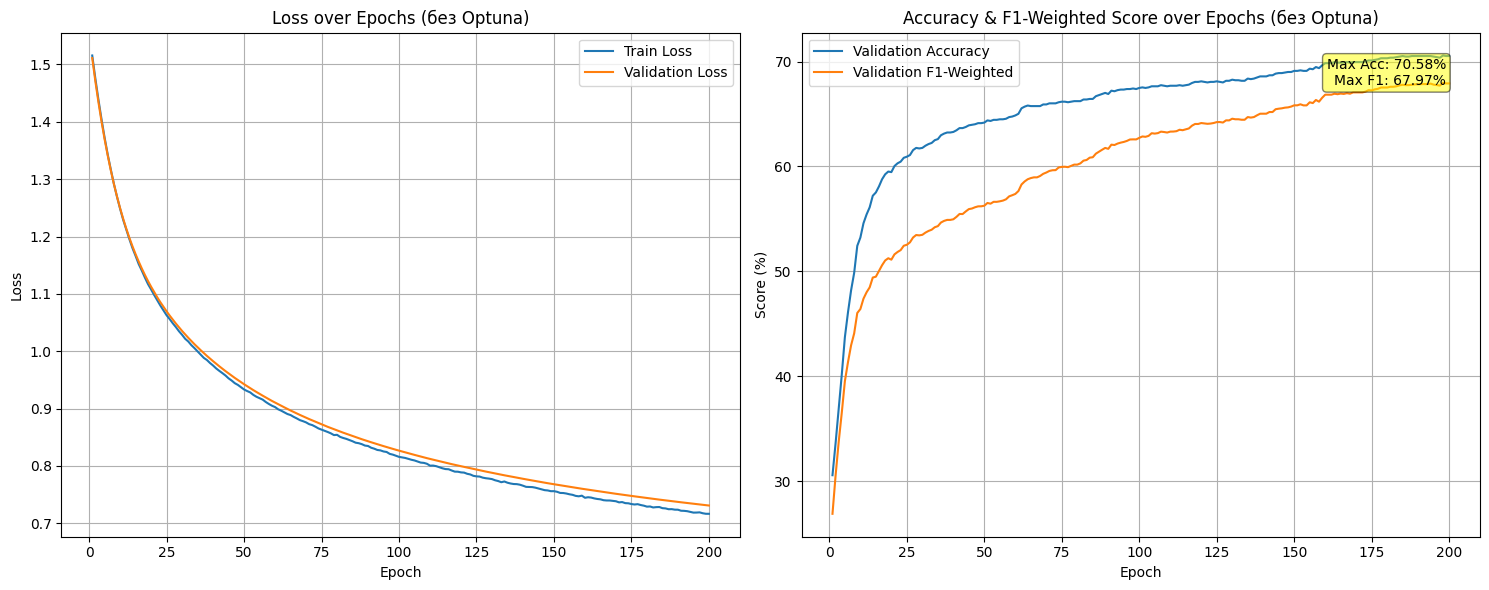


Результаты для SingleLayerPerceptronClassifier (с Optuna):


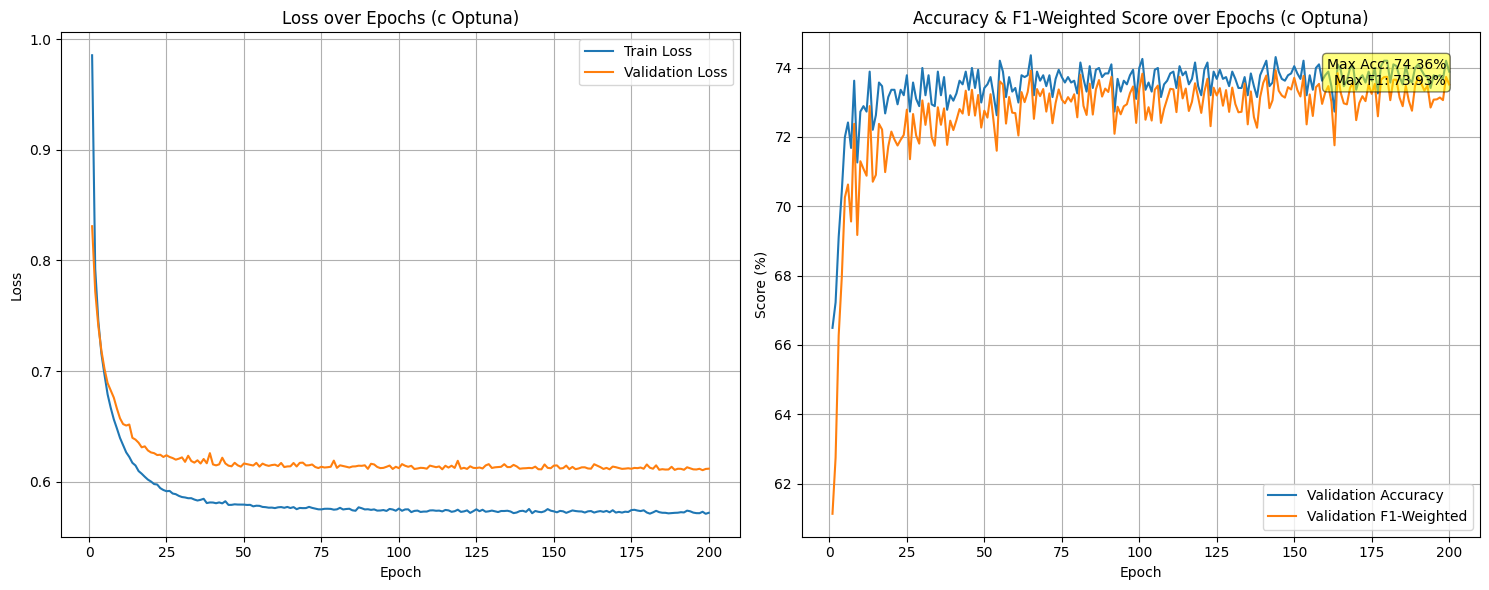


Результаты для MultiLayerPerceptronClassifier (без Optuna):


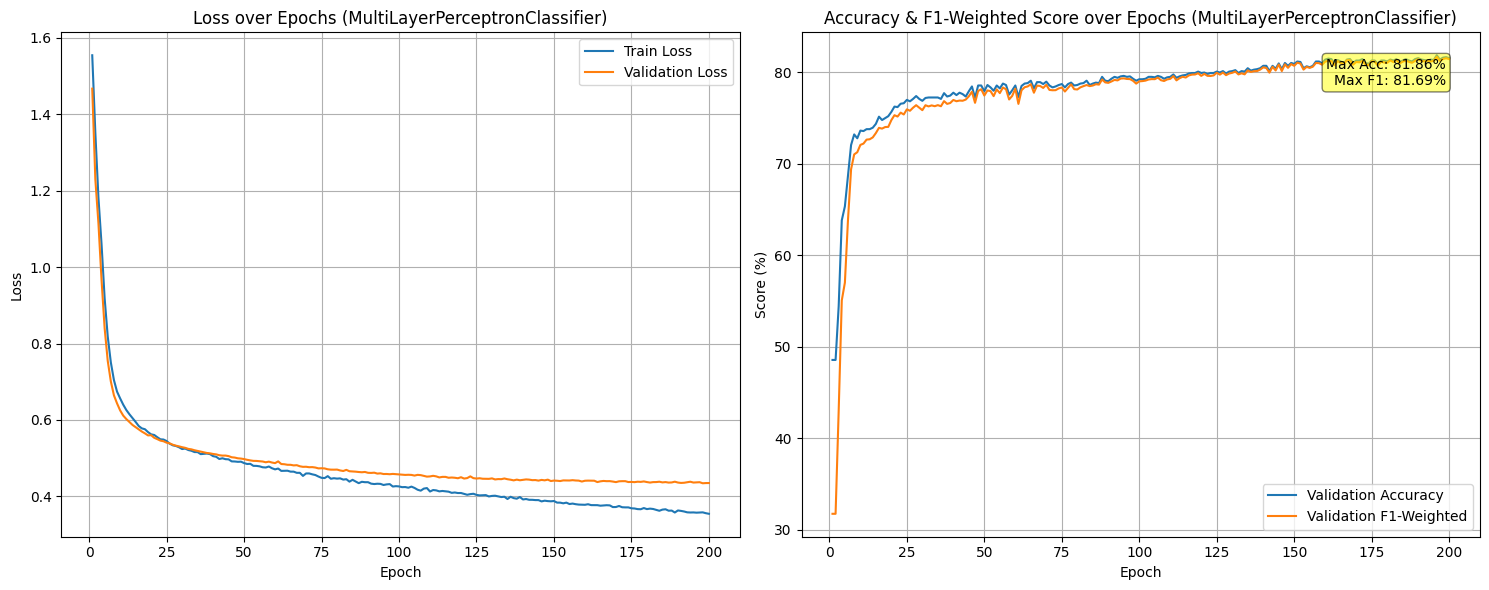


Результаты для DynamicMultiLayerPerceptronClassifier (с Optuna, объединенные):


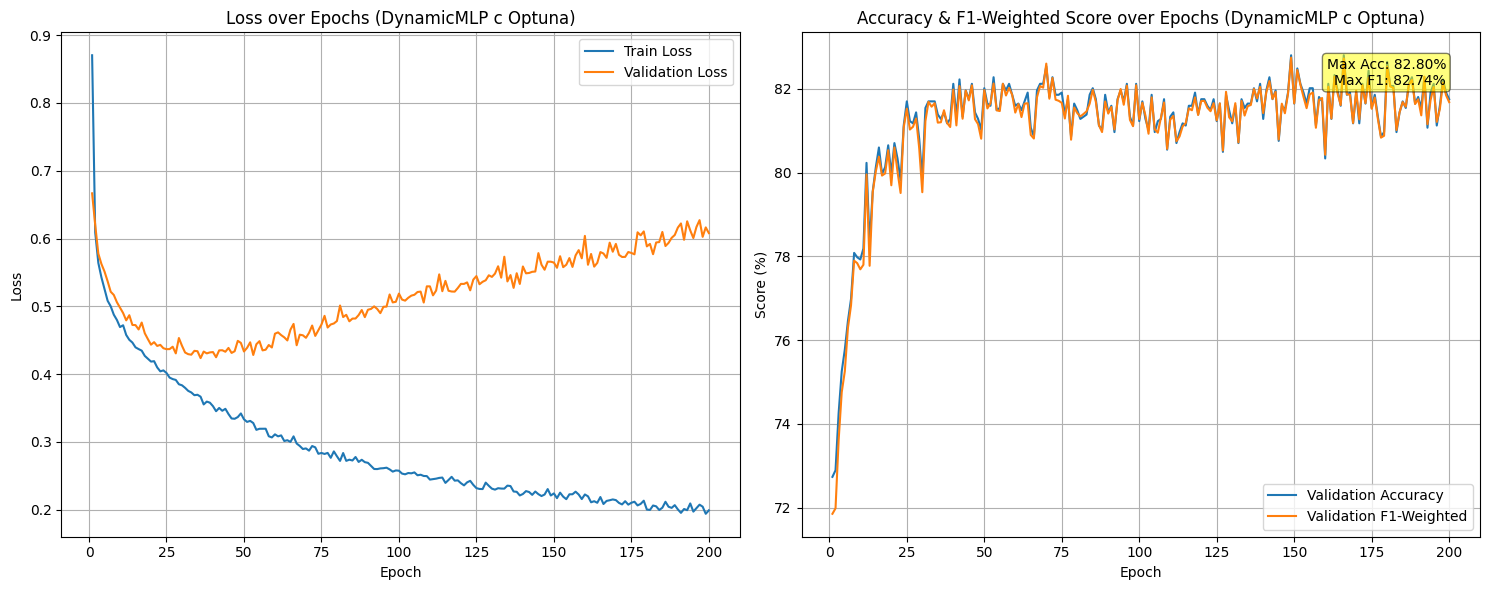


Результаты для TransformerClassifier (AdamW):


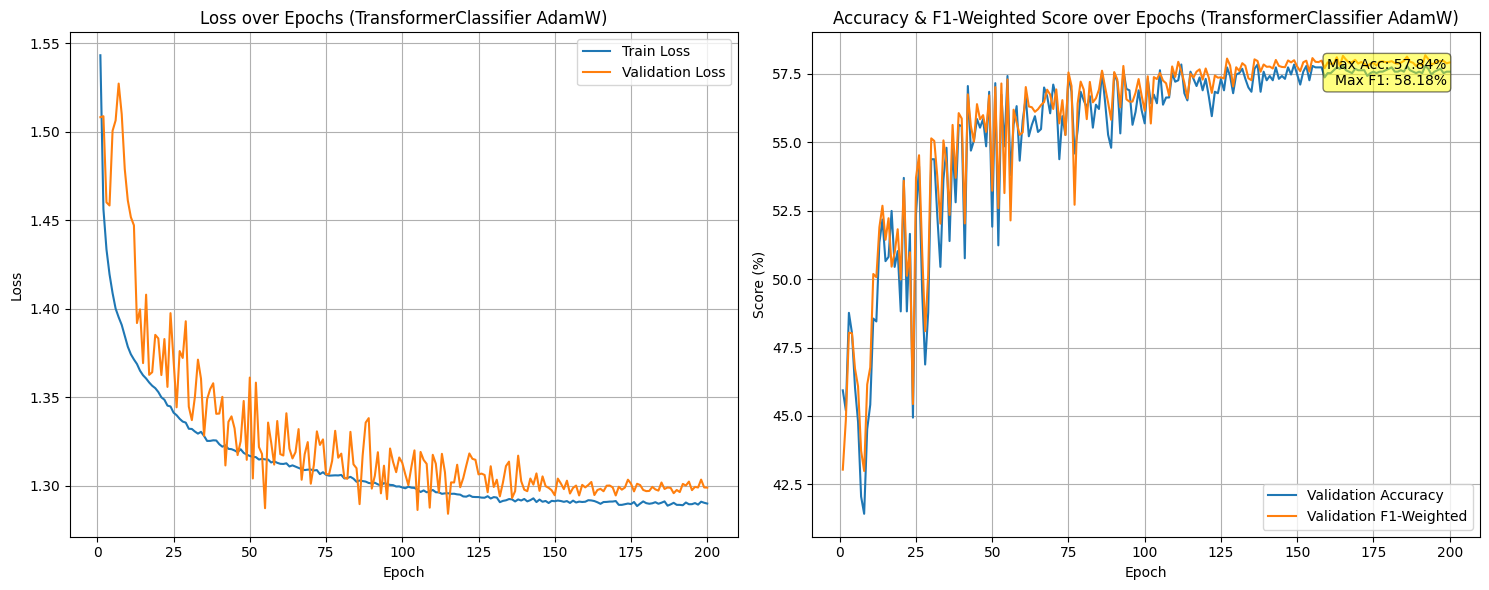


Результаты для TransformerClassifier (Adafactor):


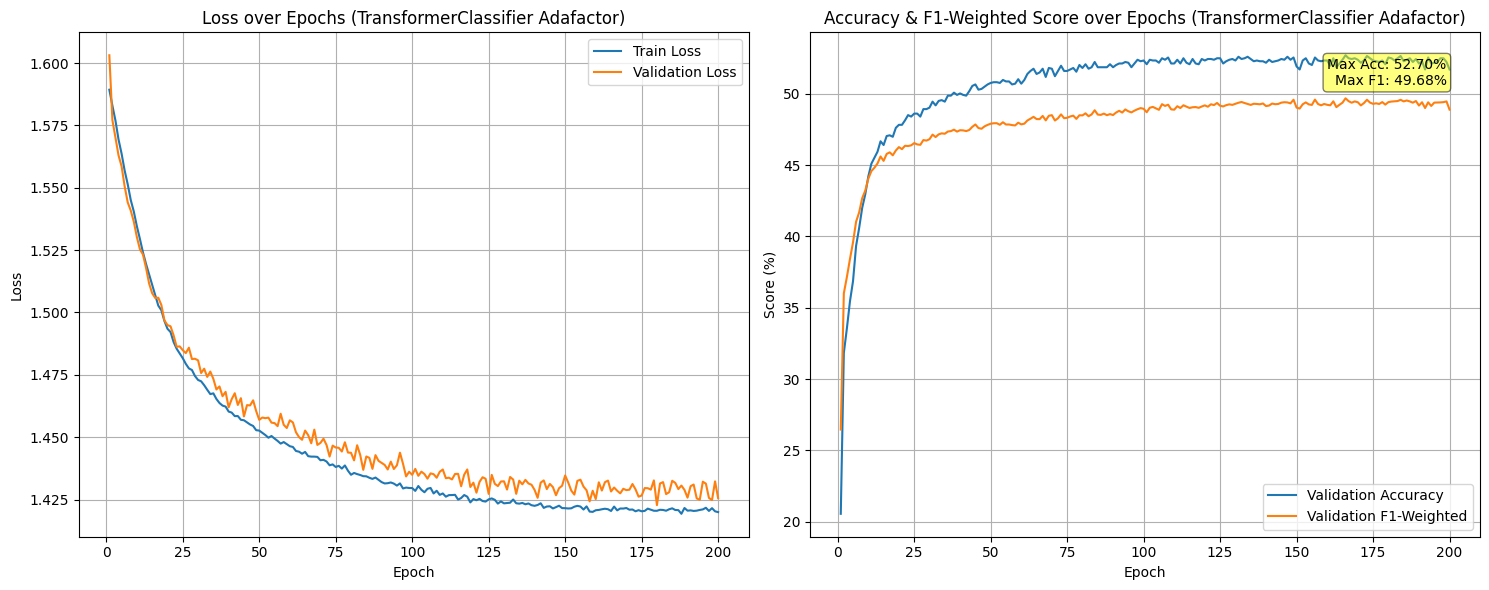


Результаты для TransformerClassifier (Shampoo):


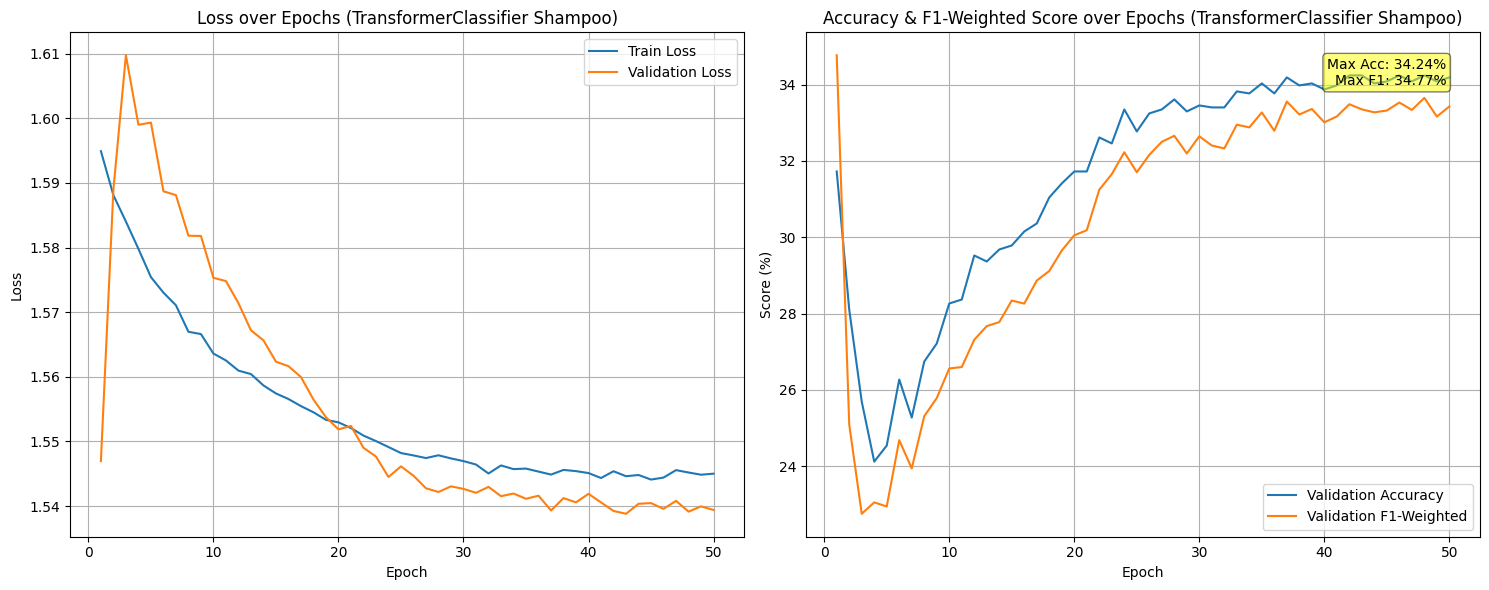

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(results, title_suffix=""):
    train_losses, eval_losses, val_accuracies, f1_weights = results
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, eval_losses, label='Validation Loss')
    plt.title(f'Loss over Epochs {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, val_accuracies, label='Validation Accuracy')
    ax2.plot(epochs, f1_weights, label='Validation F1-Weighted')
    ax2.set_title(f'Accuracy & F1-Weighted Score over Epochs {title_suffix}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score (%)')
    ax2.legend()
    ax2.grid(True)

    if len(val_accuracies) > 0:
        max_val_accuracy = max(val_accuracies)
        max_f1_weighted = max(f1_weights)
        ax2.text(0.95, 0.95, f'Max Acc: {max_val_accuracy:.2f}%\nMax F1: {max_f1_weighted:.2f}%',
                 transform=ax2.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5))

    plt.tight_layout()
    plt.show()

print("Результаты для SingleLayerPerceptronClassifier (без Optuna):")
plot_metrics(single_clf_res, "(без Optuna)")

print("\nРезультаты для SingleLayerPerceptronClassifier (с Optuna):")
plot_metrics(optuna_single_clf_res, "(с Optuna)")

print("\nРезультаты для MultiLayerPerceptronClassifier (без Optuna):")
plot_metrics(multi_clf_res, "(MultiLayerPerceptronClassifier)")

print("\nРезультаты для DynamicMultiLayerPerceptronClassifier (с Optuna, объединенные):")
plot_metrics(optuna_multi_clf_res, "(DynamicMLP с Optuna)")

print("\nРезультаты для TransformerClassifier (AdamW):")
plot_metrics(transformer_adamw_res, "(TransformerClassifier AdamW)")

print("\nРезультаты для TransformerClassifier (Adafactor):")
plot_metrics(transformer_adafactor_res, "(TransformerClassifier Adafactor)")

print("\nРезультаты для TransformerClassifier (Shampoo):")
plot_metrics(transformer_shampoo_res, "(TransformerClassifier Shampoo)")

## Вывод
Результаты в таблице

| model name | best accuracy (%)| best f1_wegthted (%)|
|----------|----------|----------|
| SingleLayerPerceptronClassifier  | 70.58 | 67.97 |
| SingleLayerPerceptronClassifier (Optuna) | 74.36 | 73.93 |
| MultiLayerPerceptronClassifier  | 81.86 | 81.69 |
| DynamicMultiLayerPerceptronClassifier  | 82.80 | 82.74 |
| TransformerClassifier (AdamW) | 57.84| 58.18 |
| TransformerClassifier (Adafactor) | 52.70 | 49.68 |
| TransformerClassifier (Shampoo) | 34.24 | 34.77 |

Наилучший результат показала модель DynamicMultiLayerPerceptronClassifier. Эта модель за счет большей сложности справляется лучше однослойных сетей, а подбор гиперпараметров позволил выиграть 1% точности. Трансформеры показали откровенно говоря плохие результаты. Это связано с тем, что они не ориентированы на табличные данные, требуют более тонкой настройки гиперпараметров (которая почти не производилась).

Матрицы ошибок в этом дз строить не стал, так как уже из метрик понятно, что нейросеть справляется хуже чем GB или RF. Хотя глобально линейные сети скорее всего тоже бы подошли для решения задачи по тем же соображениям, что и все остальные классификаторы в рамках курса. (а еще среда отключилась, а пересчитывать заново долго...)